**Comparison of longest common subsequence (LCS) algorithms**

**COT 6405 Analysis of Algorithms, Spring 2020**

**Christian Garbin**

# Introduction

This notebook compares **longest common subsequence** (defined below) algorithms:

- **Brute-force**: generates combinations of subseqences and check if they are common subsequences.
- **Dynamic programming**: takes advantage of common subproblems to not evaluate the same subsequence more than once.
- **Hirschbger's linear space**: a dynamic programming approach, combined with divide-and-conquer, that uses significantly less space than the dynamic programming algorithm.

The comparison measures:

- Runtime efficiency: how long it takes to find a longest common subsequence.
- Space efficiency: how much space is used to find a longest common subsequence.

The code used in the experiments is written in Pyhton 3.x.

# Longest common subsequence

## Definiton

Given a sequence $X = <x_1, x_2, \dots, x_m>$, another sequence $Z$ is a **subsequence** of $X$ if there is a strictly increasing sequence $<i_1, i_2, \dots, i_k>$ of indices of $X$ such that for all $j = 1, 2, \dots, k$, we have $x_{ij} = z_j$ \[CLRS01\].

For example:

- Given the sequence $X = <A, B, C, B, D, A, B>$
- The sequence $Z = <B, C, D, B>$ is a subsequence of $X$, with indices $<2, 3, 5, 7>$

Given two sequences, a **common subsequence** is a sequence that is common to both sequences. A **longest common subsequence** (LCS) is a maximum-length common subsequence.

For example:

- Given the sequences $X = <A, B, C, B, D, A, B>$ and $Y = <B, D, C, A, B, A>$
- The sequence $<B, C, A>$ is a common subsequence
- The sequence $<B, C, B, A>$ is a longest common subsequence
- The sequence $<B, D, A, B>$ is another LCS, therefore LCSs do not have to be unique

## Applications

Applications of LCS include determining if two organisms are similar by comparing their DNAs. In this case, "similar" can be determined by the longest common subsequence between the DNAs. The longer the subsequence, the more common the organisms are.

Building on the DNA example, LCS can be used as a form of compression. Using a pre-built suffix tree, an LCS-based solution compressed the human genome from about 3 GB to just over 8 MB \[BAF16\].

LCS is also used in version control systems to produce the "diff", the minimal amount of additions and deletions that transform the older version of a file into the new version, also known as the "edit distance" \[NAV01\]. For example, this output of Git's `diff` command between two versions of a file shows deletion and addition of two lines to transform the old version of the file into the new one:

````
@@ -33,15 +33,11 @@ class ModifiedFile(BaseCommit):
     '''Number of lines added to the file in this commit.'''
     deleted = Column(Integer)
-    '''Number of lines deleted from the file in tihs commit.'''
+    '''Number of lines deleted from the file in this commit.'''
-    commit_id = Column(String)
+    commit_id = Column(String, ForeignKey('commit_info.commit_id'))
````


# Notebook structure

The remainder of this notebook is structured as follows:

- **Algorithms**: describes the algorithms used in the tests.
- **Planning of experiments**: describes the experiments performed, data collected for each one, the analysis performed on them.
- **Initialization and verification**: initializes the notebook (import Python modules, set important environment values) and verifies that the algorithms are working before using them.
- **Measurement and analysis**: run the tests to collect the metrics and analyzes those metrics.
- **Code**: documents relevant pieces of the code and other technical aspects found during the development and execution of the tests.

# Algorithm descriptions

Three algorithms will be analyzed:

- Brute-force
- Dynamic programming
- Hirschberg’s linear space

In all sections below, $m$ is the lenght of the longest sequence and $n$ is the length of the shortest sequence.

## Brute-force

Brute-force is the simplest LCS algorithm: generate subsequences of the smaller sequence and check if they are also a subsequence of the larger sequence. 

The pseudocode for the algorithm is:

````
LCS_BRUTE_FORCE(X, Y)
    // Pick the shortest sequence to generate subsequences
    short_seq = shortest_of(X, Y)
    long_seq = longest_of(X, Y)

    // Try all subsequences of the shortest sequence
    for i = length(short_seq) to 1
        // Try all subsequences of length i, one at a time
        while "there are subsequences of length i to try":
            subseq = next_subsequence(short_seq, i)
            if is_subsequence(subseq, long_seq)
                return subseq
    
    // Could not find a subsequence
    return [] // empty sequence
````

**Runtime analysis**: the algorithm selects the smaller sequence to generate combinations to test. Since there are $2^n$ combinations of subsequences that can be generated from the subsequence, and each one has to be tested against the larger sequence, the runtime is $m \times 2^n$. In most cases, the second term is much larger than $m$, making it a $O(2^n)$ algorithm.

**Space analysis**: A naive implementation would generate all combinations of the smaller sequence ahead time, using $O(2^n)$ space. An optimized implementation, as shown above, generates one combination of the smaller sequence at a time, using $O(n)$ space.

## Dynamic programming

Dynamic programming makes use of the optimal substructure of the LCS, solving smaller subproblems only once, combining the solutions. 

The pseudocode is shown below. It has two parts: first two matrices are constructed to determine the LCS length and how to construct it (a series of "moves"), then the LCS is extracted by going through the moves matrix.

````
LCS_LENGTH(X, Y)
    m = length(X)
    n = length(Y)

    // c is an m x n matrix with the top row and
    // left column initialized to zero
    c = matrix(m, n)
    for i = 1 to m
        c[i, 0] = 0
    for j = 1 to n
        c[0, j] = 0

    // b is an m x n empty matrix that will hold the
    // movements to build the LCS
    b = matrix(m ,n)

    for i = 1 to m
        for j = 1 to n
            if X[i] == Y[j]
                c[i,j] = c[i-1,j-1] + 1
                b[i,j] =  "diagonal"
            else if c[i-1,j] >= c[i, j-1]
                c[i,j] = c[i-1,j]
                b[i,j] =  "up"
            else
                c[i,j] = c[i,j-1]
                b[i,j] =  "down"

    // c[m,n] has the LCS length and b has the
    // sequences of moves to extract the LCS
    return c, b

EXTRACT_LCS(b, X, i, j)
    lcs = empty_list()

    while i > 0 and j > 0
        move = b[i,j]
        if move == "diagonal"
            lcs = lcs + X[i]
            i = i - 1
            j = j - 1
        else if move == "up"
            i = i - 1
        else // "down"
            j = j - 1

    // The LCS was built from the bottom up,
    // need revert it before returning
    return reverse(lcs)

LCS(X, Y)
    b, c = LCS_LENGTH(X, Y)
    lcs = EXTRACT_LCS(b, X, length(X), length(Y))
    return lcs
````

**Runtime analysis**: the `LCS_LENGTH` part of the algorithm is $O(m \times n)$, from its two nested loops. The `EXTRACT_LCS` is $O(m+n)$. For large values of $m$ and $n$, `LCS_LENGTH` dominates the runtime, making the algorithm overall $O(m \times n)$.

**Space analysis**: the $m \times n$ matrix in `LCS_LENGTH` is responsible for the space the algorithm needs, thus the space is $O(m \times n)$.

## Hirschberg’s linear space

Hirschberg’s linear space algorithm \[HIR75\] is a dynamic programming approach that uses divide-and-conquer. As the name indicates, it makes efficient use of space.

The pseudocode is shown below. It has two parts: a _scoring_ (also called _cost_) function to help decide where to divide the current subsequence being analyzed, and the function that divides-and-conquers, based on that score.

````
SCORE(X, Y)
    m = length(X)
    n = length(Y)

    // A list of of scores, initialized with n zeros
    scores = list(0 * n)

    for i = 1 to m
        prev_score = scores
        for j = 1 to n
            if X[i] == Y[j]
                scores[j+1] = prev_scores[j] + 1
            else
                scores[j+1] = max(scores[j], prev_scores[j + 1])
    
    return scores

LCS(X, Y)
    m = length(X)
    n = length(Y)
    if m == 0
        // Got to the end of the sequence
        return []
    else if m == 1
        // Last character, check if it is in subsequence
        if X[1] is in Y
            return X[1]
        else
            return []
    else
        // Find where to split the current sequences

        // X is split in the middle
        i = m / 2
        XB = X[i:i]
        XE = X[i+1:m]

        // Y is split based on the scores
        cost_top_left = SCORE(XB, Y)
        cost_bottom_right = SCORE(reverse(XE), reverse(Y)))
        cost = cost_top_left + reverse(cost_bottom_right)

        k = index of max(cost) // argmax(cost)
        YB = Y[1:k]
        YE = Y[k+1:n]

        // Solve for each part of the split sequences
        return LCS(XB, YB) + LCS(XE, YE)
````

**Runtime analysis**: in each step, the sequences under examination are split into two subquences at $m / 2$ and a _q_ based on a cost factor (this is the secret cause of the algorithm). It can be shown that the recurrence is $O(mn)$ \[KT05\] \[FAG16\].

**Space analysis**: a naive implementation of the algorithm creates copies of the sequences as it splits them during the recursive calls, using space $O(m + n)$. An implmentation that passes the original sequences around and uses indices to logically split them (without creating copies), uses space $O(min(m, n))$ (in the `SCORE` fuction).

## Runtime and space summary

The following table summarizes the runtime and space characteristics of the algorithms.

| Algorithm | Runtime | Space |
|-|-|-|
| Brute-force | $O(2^n)$ | $O(n)$ |
| Dynamic programming | $O(m \times n)$ | $O(m \times n)$ |
| Hirschberg | $O(m \times n)$ | $O(min(m,n))$ |

# Planning of experiments

The experiments compare the runtime and space of the brute-force, dynamic programming recursive, and Hirchberg's linear space algorithms.

To illustrate the algorithms in a typical application, the tests will use two strings that resemble DNA sequences (a combination of the letters `A`, `C`, `G`, and `T`) and will find an LCS for them. To emulate the computational biology case of searching for a common substring between two DNA strands, in each case we will search for a string that is one-tenth of the larger strings, illustrated in the table below.

## Input size for tests

Strings of three sizes will be used, small, medium, large. For each size, the same strings will be used with all algorithms, to keep the comparison consistent.

| Test size |  The DNA strain (X)<br>This is the _m_ in RT and space analysis | The possible common sequence (Y)<br>This is the _n_ in RT and memory analysis |
|-|-:|-:|
| Small  |   1,000 |   100  |
| Medium |  10,000 |  1,000 |
| Large  | 100,000 | 10,000 |
Table 1 - Size of strings to test and how they map to the m and n of the RT and memory analysis.

## Runs

Each algorithm will be executed ten times (k=10) for each string size to remove variations in the environment. The average of these runs will be used as the final number for the algorithm.

Two values will be measured in each run, running time (RT) and memory (space) usage:

- Time: measured with Python's [`time` package](https://docs.python.org/3/library/time.html).
- Memory: measured with Python's [`memory_profiler` package](https://pypi.org/project/memory-profiler/).

Details of how measurements were conducted are documented in the code section, later in this document.

## Data structures

Experimental data, the strings, will be stored in the standard data structures for string representation, usually mapped to a constant-time access continuous array in programming languages. Auxiliary data structures to keep track of intermediate results will be kept either in Pythnon arrays on NumPy arrays, whichever is more performant for a specific piece of code.

## Input generation

Strings for the tests will be generated using a pseudo-random number generation initialized with a seed, to ensure the repeatability of the experiments (the same sequence is generated every time). The strings will be generated only once, before each algorithm is executed, to ensure that the results can be compared with each other.

## Graphs and tables

For each algorithm, two tables will be filled in:

- RT analysis: theoretical vs. empirical RT.
- Memory usage: theoretical vs. empirical memory usage.

The following table illustrates the RT analysis for the brute-force algorithm.

| Test size | Theoretical complexity |  Empirical RT (ms) | Ratio (empirical RT / theoretical complexity | Predicted RT | % error |
|-|-|-|-|-|-|
| Small<br> m=1,000, n=100 | $2^n$ = $2^{100}$ | | | | |
| Medium<br> m=10,000, n=1,000 | $2^n$ = $2^{1000}$ | | | | |
| Large<br> m=100,000, n=10,000 | $2^n$ = $2^{10000}$ | | | | |
Table 2 - RT analysis table example, using the brute-force algorithm as illustration

The table columns are computed as follows:

- _Ratio_ measures the ratio between the empirical and the theoretical complexity. Its value is always > 0. It is used to calculate the constant _c_.
    - The constant _c_ measures the overhead of the steps (computer instructions) that are outside the main loops (or recursive calls) of the algorithms. It is determined as the maximum of the ratio values (with outliers discarded), i.e. the maximum value of the _Ratio_ column.
- _Predicted RT_ is computed as the constant _c_ times the _Theoretical complexity_.
- _% error_ measures the discrepancy between the predicted and the empirical time: _(Empirical RT - Predicted RT) / Empirical RT * 100_.

The following table illustrates memory usage for the brute-force algorithm.

| Test size | Theoretical memory usage (KiB) | Empirical memory usage (KiB) | % error |
|-|-|-|-|
| Small<br>m=1,000, n=100 | n  / 1024 = 0.98 | |
| Medium<br>m=10,000, n=1,000 | 9.8 | |
| Large<br>m=100,000, n=10,000 | 97.7 | |
Table 3 - Memory usage analysis table example, using the brute-force algorithm as illustration

The table columns are computed as follows:

- _Theoretical memory usage_ is the number of characters needed, times 1 byte per character, divided by 1,024 to transform to KiB.
    - "1 byte per character" comes from the variable-length encoding of strings in Python using the CPython environment. Because we are representing DNA strands, we are using only ASCII characters, which are represented as 1 byte \[CPY20\] \[GOL20\].
- _% error_ measures the discrepancy between the theoretical and empirical memory usage: _Empirical memory usage / Predicted memory usage) / Empirical memory usage * 100_.

For the other algorithms, the theoretical values will be adjusted as follows:

- Dynamic programming:
    - Theoretical RT = $m \times n$
    - Theoretical memory usage = $m \times n$
- Hirschberg’s linear space algorithm
    - Theoretical RT = $m \times n$
    - Theoretical memory usage = $m + n$

Once the tables are filled in, two sets of graphs will be created:

- **Algorithm comparison**: this set of graphs compares the empirical runtime and memory usage of the algorithms. There will be one runtime and one memory usage plot for all algorithms (two graphs).
- **Theoretical vs. empirical results**: this set of graphs compares the empirical runtime and memory usage of each algorithm. There will be one set of plots for each algorithm and each size, for a total of 9 graphs (3 algorithms, 3 sizes).

The following graphs will be generated for algorithm comparison:

- RT comparison: a horizontal bar graph with the runtime in ms (horizontal axis) for each algorithm, grouped by the input size. A horizontal bar graph will be used because of the expected large values for large input sizes. This representation makes better use of space.
- Memory comparison: similar to the graph above, using memory usage as the horizontal axis.

The following graphs will be generated for each algorithm for the theoretical vs. empirical results:

- Theoretical vs. empirical runtime in ms for each input size
- Theoretical vs. empirical memory usage in KiB for each input size

## Programming language

The experiments use Python 3.x in a Jupyter Notebook environment.

# Initialization and verification

Load commonly-used modules.

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 3)

Check that the algorithms work by testing them against controlled input.

There are three part to the tests:

1. Automated tests that check against well-defined inputs. They are meant to be easy to debug, in case an algorithm fails.
1. Tests with longer inputs that simular DNA strands. They test more realistic scenarios, but still short enough to run fast.
1. A visual check, by printing the aligned subsequence. They guard against the test code itself having a failure that generates false positives.

In [3]:
import lcs_test

lcs_test.test(visualize=True)

All basic tests passed
All DNA tests passed
Visual inspection:
                         lcs_brute_force:  TACCGCATTATCGATACTTTTACCGACAAC
                         lcs_brute_force:  ....G.......G.T.CTTT.A...ACAA. size=12
    lcs_dynamic_programming_matrix_numpy:  ....G.......G.T.CTTT.A...ACAA. size=12
                    lcs_hirschberg_numpy:  ....G.......G.T.CTTT.A...ACAA. size=12


# Runtime tests and analysis

To illustrate a real-life scenario, the code checks if a DNA strand is part of
a larger DNA sequence \[WIK20a\].

In [117]:
# Force reload because this piece of code frequently changes
import importlib
import metrics as m
importlib.reload(m);

## Constant _c_ calculation

This section calculates the constant _c_ for each algorithm. This is the constant that accounts for instructions that are not in the loops. For example, given a runtime $O(n^2)$, the constant _c_ allows us to write the runtime more precisely as $c \times n^2$. 

The constant is also affected by the language and compiler or intepreter used. In this notebook it is calculated with dynamic analysis: run the code and calculate the overhead.

Each algorithm was executed once with different input sizes, with the pairs representing the length of X and Y, respectively: (1,000, 100), (2,000, 200), (3,000, 300), (4,000, 300), (4,000, 500), (4,000, 1,000).

Once the algorithms are run, we calculate _c_ as $max (rt1, rt2, ...., rt_n)$, excluding outliers where applicable.

In [9]:
rt_results_raw, rt_results_summary = m.runtime(m.seq_phase1, verbose=1,
    file='runtime-phase1')

Loading from file


We now have two Pandas DataFramse:

- `rt_results_raw`: results from all 10 executions of each algorithms and each input size.
- `rt_results_summary`: average of the executions for each each algorithm and input size.

Using these DataFrames, the following sections calculate three constants, one for each algorithm. They are stored in the following variables:

- `c_bf`: the constant for the brute-force algorithm.
- `c_dp`: the constant for the dynamic programming algorithm.
- `c_h`: the constant for the Hirschberg linear space algorithm.

The DataFrames contain metrics for all algorithms. Sections below filters the row for the algorithm analyzed in that section.

### Constant _c_ for brute-force

In [111]:
rt_bf, c_bf = m.add_runtime_analysis(rt_results_summary, m.ALG_BRUTE_FORCE)
print('c_bf={}'.format(c_bf))
display(rt_bf)

c_bf=1.0634233481341651e-151


,Algorithm,Sequence size,Subsequence size,Empirical RT (ms),Theoretical complexity,Ratio,Predicted RT,% error
0,Brute-force,10000,500,0.348,"3,273,390,607,896,141,870,013,189,696,827,599,1...",0.000,0.348,0.000
1,Brute-force,10000,800,0.462,"6,668,014,432,879,854,274,079,851,790,721,257,7...",0.000,"709,092,223,362,003,099,602,564,470,398,529,784...","-153,616,166,239,647,956,793,058,318,974,150,63..."
2,Brute-force,10000,1000,0.600,"10,715,086,071,862,673,209,484,250,490,600,018,...",0.000,"1,139,467,270,608,596,355,110,469,839,799,148,1...","-189,816,303,615,624,870,299,954,810,380,574,01..."
3,Brute-force,20000,1000,0.645,"10,715,086,071,862,673,209,484,250,490,600,018,...",0.000,"1,139,467,270,608,596,355,110,469,839,799,148,1...","-176,688,985,984,728,516,776,248,563,895,530,23..."
4,Brute-force,20000,2000,1.181,inf,0.000,inf,-inf
5,Brute-force,20000,2500,1.551,inf,0.000,inf,-inf
6,Brute-force,30000,2000,1.848,inf,0.000,inf,-inf
7,Brute-force,30000,3000,1.774,inf,0.000,inf,-inf
8,Brute-force,30000,4000,2.397,inf,0.000,inf,-inf


We can see in the table a very large error for most tests of the brute-force algorithm. This is caused by the "luck factor" of this algorithm: if we are lucky and generate a combination early on that happens to be a common subsequence, the algorithm terminates quickly. The probability of generating a common subsequence is high in this case because of the reduced amount of possible combinations we have when using only the four letter of a DNA sequence.

Given the "luck factor" of this case, analyzing the predicted vs. empirical runtime will not be insightful.

###  Constant _c_ for dynamic programming

In [113]:
rt_dp, c_dp = m.add_runtime_analysis(rt_results_summary, m.ALG_DYNAMIC_PROGRAMMING)
print('c_dp={}'.format(c_dp))
display(rt_dp)

c_dp=0.00016289664


,Algorithm,Sequence size,Subsequence size,Empirical RT (ms),Theoretical complexity,Ratio,Predicted RT,% error
9,Dynamic programming,10000,500,814.483,5000000,0.000,814.483,0.000
10,Dynamic programming,10000,800,"1,248.201",8000000,0.000,"1,303.173",-4.404
11,Dynamic programming,10000,1000,"1,580.510",10000000,0.000,"1,628.966",-3.066
12,Dynamic programming,20000,1000,"3,016.303",20000000,0.000,"3,257.933",-8.011
13,Dynamic programming,20000,2000,"6,086.177",40000000,0.000,"6,515.866",-7.060
14,Dynamic programming,20000,2500,"7,619.874",50000000,0.000,"8,144.832",-6.889
15,Dynamic programming,30000,2000,"9,090.383",60000000,0.000,"9,773.798",-7.518
16,Dynamic programming,30000,3000,"13,684.828",90000000,0.000,"14,660.698",-7.131
17,Dynamic programming,30000,4000,"18,055.193",120000000,0.000,"19,547.597",-8.266


Since all results are within a small margin of error, none of them will be discarded for the calculation.

###  Constant _c_ for Hirschberg's linear space

In [114]:
rt_h, c_h = m.add_runtime_analysis(rt_results_summary, m.ALG_HIRSCHBERG)
print('c_h={}'.format(c_h))
display(rt_h)

c_h=0.000324546


,Algorithm,Sequence size,Subsequence size,Empirical RT (ms),Theoretical complexity,Ratio,Predicted RT,% error
18,Hirschberg,10000,500,"1,622.730",5000000,0.000,"1,622.730",0.000
19,Hirschberg,10000,800,"2,496.766",8000000,0.000,"2,596.368",-3.989
20,Hirschberg,10000,1000,"3,053.377",10000000,0.000,"3,245.460",-6.291
21,Hirschberg,20000,1000,"6,086.664",20000000,0.000,"6,490.920",-6.642
22,Hirschberg,20000,2000,"12,056.323",40000000,0.000,"12,981.840",-7.677
23,Hirschberg,20000,2500,"15,022.464",50000000,0.000,"16,227.300",-8.020
24,Hirschberg,30000,2000,"18,018.597",60000000,0.000,"19,472.760",-8.070
25,Hirschberg,30000,3000,"26,760.298",90000000,0.000,"29,209.140",-9.151
26,Hirschberg,30000,4000,"35,573.312",120000000,0.000,"38,945.520",-9.480


Some of the results are of by more than 10%, but not by much, so we will keep all of them for the calculation.

## Empirical vs. predicted RT graphs

The graphs below compare the empirica runtime with the predicted runtime using the smaller input sizes. The predicted runtime is calcutated as _c_ $\times$ _theoretical complexity_.

Each of the graphs below shows the empirical vs. predicted runtime for an algorithm. The empirical runtime is the actual running time of the algorithms, while the empirical runtime is calculated as _c_ $\times$ the theoretical complexity.

From these graphs we can see that:

1. The brute-force graph shows again the "luck" effect, where the runtime is low because a subsequence
   just happens to be found early on. It could have gone the other way, as it in fact did in one of the
   experiments, where after running for eight hours, it still did not find a common subsequence for
   m = 5,000 and n 2,000.
1. Both the dynamic programming and the Hirschberg algorithms track closely to their predicted runtime.
1. The Hirschberg algorithm's error is larger for larger input sizes, likely because the nature of the
   implementation and the programming language. It is a recursive algorithm and Python does not support
   tail recursion optimization \[WIK20b\] \[ROS09\]. Thus the loops have the extra cost of function
   calls that the dynamic programming algorithm does not have. The cost of the function calls is
   relatively more expensive for small input size, resulting 
   in overstimating _c_. An improvement for
   this case could be to do a more rigorous outlier elimination when calculating _c_.

In [15]:
graph_number = 0
def plot_empirical_predicted_rt(data, title):
    '''Auxiliary function to plot the graphs consistently for all algorithms.'''
    global graph_number
    graph_number +=1
    fig = plt.figure(figsize=(10,4))
    sns.lineplot(x=m.DF_THEORETICAL_COMPLEXITY, y=m.DF_EMPIRICAL_RT, data=data)
    sns.lineplot(x=m.DF_THEORETICAL_COMPLEXITY, y=m.DF_PREDICTED_RT, data=data)
    plt.title('Graph {} - {} empirical vs. predicted runtime'.format(
        graph_number, title))
    plt.ylabel("Runtime (ms)")
    fig.legend(['Empirical', 'Predicted'], bbox_to_anchor=(0.3, 0.8))
    plt.show()

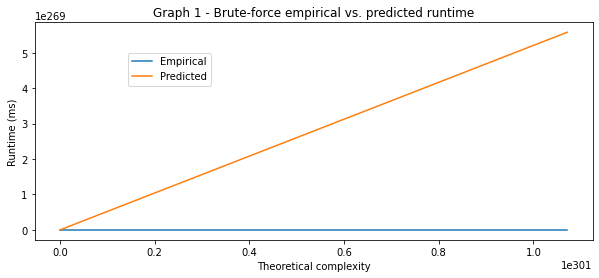

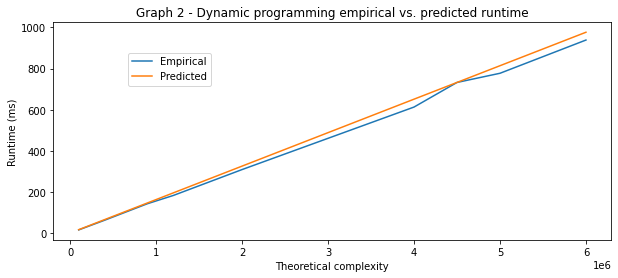

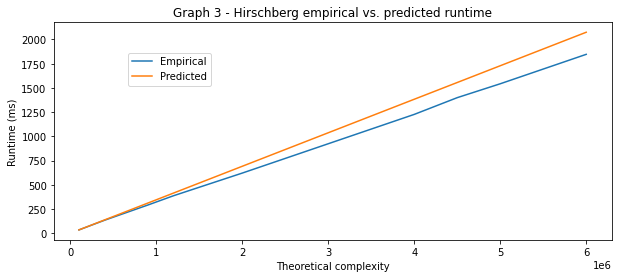

In [16]:
for alg in (rt_bf, rt_dp, rt_h):
    plot_empirical_predicted_rt(alg, alg.iloc[0][m.DF_ALGORITHM])

## Graphs for larger input sizes

The graphs below compare the empirical runtime with the predicted runtime using the larger input sizes. As before, the predicted runtime is calcutated as _c_ $\times$ _theoretical complexity_.

The graphs show the same trend lines as the graphs for the smaller input sizes.

In [17]:
rt_results_raw, rt_results_summary = m.runtime(m.seq_phase2, verbose=1,
    file='runtime-phase2')

Loading from file


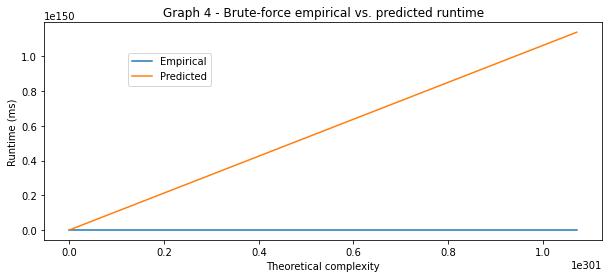

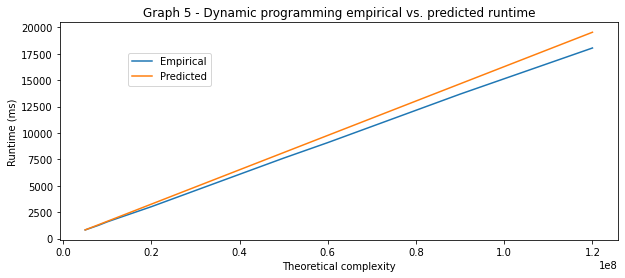

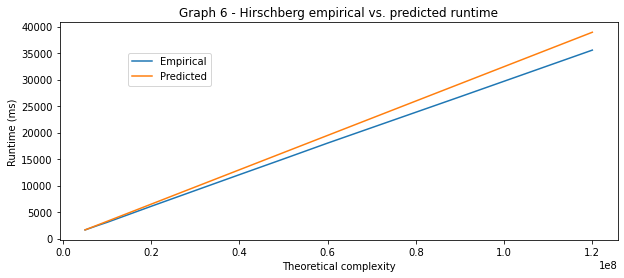

In [19]:
for alg in (m.ALG_BRUTE_FORCE, m.ALG_DYNAMIC_PROGRAMMING, m.ALG_HIRSCHBERG):
    rt, _ = m.add_runtime_analysis(rt_results_summary, alg)
    plot_empirical_predicted_rt(rt, rt.iloc[0][m.DF_ALGORITHM])

Graphing the algorithms separately does not clearly show how their runtime compare with each other. The graph below shows the dynamic programming and the Hirschberg algorithm with the same scale for the vertical axis (the brute-force algorithm is not shown because its complexity is in another scale entirely, therefore not comparable with the other two algorithms).

With this graph we can see that although they have the same growth rate (both have $O(mn)$ complexity), the Hirschberg algorithm has a higher slope, resulting from its higher _c_ constant.

In [21]:
dp_summary, _ = m.add_runtime_analysis(rt_results_summary, m.ALG_DYNAMIC_PROGRAMMING)
h_summary, _ = m.add_runtime_analysis(rt_results_summary, m.ALG_HIRSCHBERG)
summary = pd.concat([dp_summary, h_summary])


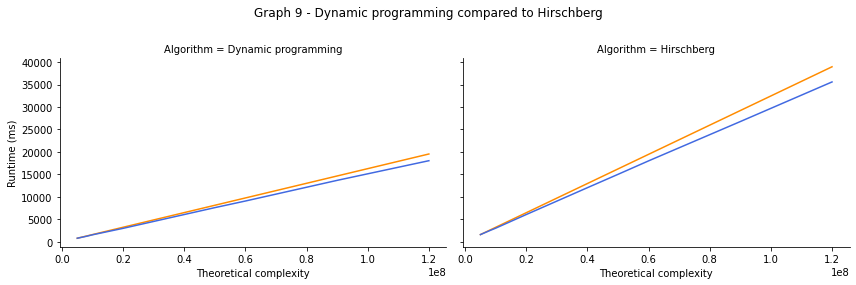

In [24]:
graph_number += 1
g = sns.FacetGrid(summary, col=m.DF_ALGORITHM, height=4, aspect=1.5)
g.map(plt.plot, m.DF_THEORETICAL_COMPLEXITY, m.DF_PREDICTED_RT,
    color='darkorange')
g.map(plt.plot, m.DF_THEORETICAL_COMPLEXITY, m.DF_EMPIRICAL_RT,
    color='royalblue')
g.set_ylabels('Runtime (ms)').fig.subplots_adjust(top=0.8)
g.fig.suptitle('Graph {} - Dynamic programming compared to Hirschberg'.format(
    graph_number))
plt.show()

# Space tests and analysis

In [118]:
mem_results_raw, mem_results_summary = m.memory(m.seq_phase2, verbose=1,
    file='memory-phase2')
mem_results_summary = m.add_memory_analysis(mem_results_summary)

Loading from file


We now have two Pandas DataFramse:

- `mem_results_raw`: results from all 10 executions of each algorithms and each input size.
- `mem_results_summary`: average of the executions for each each algorithm and input size.

The DataFrames contain metrics for all algorithms. Sections below filters the row for the algorithm analyzed in that section.

The table below shows the empirical and predicted space in MiB. Using these values, an eror column is also shown.

Observations from this table:

1. Measuring small amounts of memory used in short period of times, as used by the brute-force
   algorithm in all cases and by the other algorithms with smaller input sizes, is unreliable.
   There is a discussion about the method used later in the notebook, in the code section.
1. As the runtime increases and the amount of memory used grows larger, the measurements become
   more reliable.

In [127]:
for alg in [m.ALG_BRUTE_FORCE, m.ALG_DYNAMIC_PROGRAMMING, m.ALG_HIRSCHBERG]:
    df = mem_results_summary[mem_results_summary[m.DF_ALGORITHM] == alg]
    print('\n{} memory analysis'.format(alg))
    display(pd.pivot_table(df, values=[m.DF_EMPIRICAL_SPACE, m.DF_PREDICTED_SPACE, m.DF_ERROR],
     index=[m.DF_SEQ_SIZE, m.DF_SUBSEQ_SIZE]))


Brute-force memory analysis


% error  Empirical space (MiB)  \
Sequence size Subsequence size                                   
10000         500                  -inf                  0.000   
              800                  -inf                  0.000   
              1000                 -inf                  0.000   
20000         1000                 -inf                  0.000   
              2000                 -inf                  0.000   
              2500               38.965                  0.004   
30000         2000                 -inf                  0.000   
              3000               75.586                  0.012   
              4000               87.793                  0.031   

                                Predicted space (MiB)  
Sequence size Subsequence size                         
10000         500                               0.000  
              800                               0.001  
              1000                              0.001  
20000         1000                              0.001  
              2000                              0.002  
              2500                              0.002  
30000         2000                              0.002  
              3000                              0.003  
              4000                              0.004


Dynamic programming memory analysis


% error  Empirical space (MiB)  \
Sequence size Subsequence size                                       
10000         500              -162,660.417                  0.012   
              800                     0.134                 30.559   
              1000                    0.167                 38.211   
20000         1000                    0.101                 76.371   
              2000                    0.058                152.676   
              2500                    0.047                190.824   
30000         2000                    0.057                229.012   
              3000                    0.037                343.449   
              4000                    0.029                457.895   

                                Predicted space (MiB)  
Sequence size Subsequence size                         
10000         500                              19.073  
              800                              30.518  
              1000                             38.147  
20000         1000                             76.294  
              2000                            152.588  
              2500                            190.735  
30000         2000                            228.882  
              3000                            343.323  
              4000                            457.764


Hirschberg memory analysis


% error  Empirical space (MiB)  \
Sequence size Subsequence size                                   
10000         500                  -inf                  0.000   
              800                92.188                  0.039   
              1000               91.862                  0.047   
20000         1000               91.862                  0.047   
              2000               91.862                  0.094   
              2500               91.862                  0.117   
30000         2000               86.979                  0.059   
              3000               97.287                  0.422   
              4000               97.543                  0.621   

                                Predicted space (MiB)  
Sequence size Subsequence size                         
10000         500                               0.002  
              800                               0.003  
              1000                              0.004  
20000         1000                              0.004  
              2000                              0.008  
              2500                              0.010  
30000         2000                              0.008  
              3000                              0.011  
              4000                              0.015

Based on these observations, the results from the brute-force algorithm will not be used in further analysis. They are also not the most interesting ones, as we can see in the code that at any given time we need space to hold at most one subsequence.

Memory analysis for the dynamic programming and Hirschberg's linear space are more interesting.

Before going into the details, a review of some implementation details that affect the space characteristics of the algorithms:

1. The classic dynamic programming algorithm uses two $m \times n$ matrices, one for the length and
   another for the direction of the moves. Space-optimized implementations combine these matrices
   into one, reserving bits in each cell for the length and direction. Such an implementation was
   used here. It is discussed in the code section of the notebook.
1. Hirschberg's traditional implementation is recursive. In languages that do not support tail
   recursion, such as Python, each recursion creates a new stack frame. Thus, some of the memory
   used by the algorithm is in the form of the stack frames, in addition to the arrays it needs
   for the algorith itself. 
1. Also for Hirschberg's, a simplistic implementation of the algorithm creates copies of the
   sequences as it finds where to split them. A space-optimized algorith uses indices into the
   original sequence to avoid creating copies. Such an implementation was used here. It is
   discussed in the code section of the notebook.

With that in mind, from the tables we observe that:

1. The dynamic programming algorithm tracks closely to the predicted space. This is due to
   two factors. First, it uses a large amount of memory, which seems to favor this particular
   method of measuring memory utilization (discusion in the code section). And second, it uses
   loops, as opposed to recursion, which does not create the overhead of stack frames (in
   languages without tail recursion).
1. The Hirschberg's linear space algorithm has a large error. This error is likely caused
   by it being a recursive algorithm. Some of the memory measured during the execution comes
   from the stack frames created in each recursion.

Finally, the most important observation is the difference between the dynamic programming and Hirschberg's linear space algorithm. As expected, dynamic programming uses significantly more memory.

On the other hand, in this implementation, dynamic programming is twice as fast as Hirschberg's. In another programming language, with better support for tail recursion, their performance may be comparable.

In most real-life applications, with large input sizes, a fine-tuned implementation of Hirschberg's linear space is the preferable option. In some cases, for very large input sizes, it may be the only feasible option.

To illustrate the dramatic difference in space, the graph below shows the two algorithms side-by-side, for each input size.

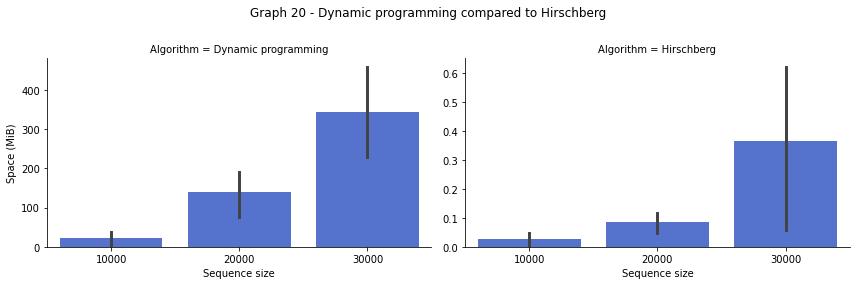

In [150]:
graph_number += 1
df = mem_results_summary[(mem_results_summary[m.DF_ALGORITHM] == m.ALG_DYNAMIC_PROGRAMMING) | (mem_results_summary[m.DF_ALGORITHM] == m.ALG_HIRSCHBERG)]
g = sns.FacetGrid(df, col=m.DF_ALGORITHM, height=4, aspect=1.5, sharey=False)
g.map(sns.barplot, m.DF_SEQ_SIZE, m.DF_EMPIRICAL_SPACE,
    color='darkorange')
g.map(sns.barplot, m.DF_SEQ_SIZE, m.DF_EMPIRICAL_SPACE, 
    color='royalblue')
g.set_ylabels('Space (MiB)').fig.subplots_adjust(top=0.8)
g.fig.suptitle('Graph {} - Dynamic programming compared to Hirschberg'.format(
    graph_number))
plt.show()

# Conclusions

# Code structure and description

## Code structure

## How reproducibility is ensured

## How time was measured

## How memory was measured

## Code optimizations


# References

\[BAF16\] Beal, R., Afrin, T., Farheen, A. et al. 2016. _A new algorithm for “the LCS problem” with application in compressing genome resequencing data_. BMC Genomics 17, 544 (2016). https://doi.org/10.1186/s12864-016-2793-0, accessed 2020-03-16.

\[CLRS01\] Cormen, T., Leiserson, C., Rivest, R., and Stein, C. 2001. *Introduction to Algorithms*, 2<sup>nd</sup> edition. MIT Press.

\[CPY20\] _The CPython source code_. https://github.com/python/cpython/blob/v3.6.3/Include/unicodeobject.h#L202, accessed 2020-03-18.

\[FAG16\] Fagerberg, R. 2016. _Dynamic Programming: Hirschberg’s Trick_. https://imada.sdu.dk/~rolf/Edu/DM823/E16/Hirschberg.pdf, accessed 2020-04-25.

\[GOL20\] Golubin, A. _How Python saves memory when storing strings_. https://rushter.com/blog/python-strings-and-memory/, accessed 2020-03-18.

\[HIR75\] Hirschberg, D. _A linear space algorithm for computing maximal common subsequences._ Commun. ACM 18 (1975): 341-343.

\[KT05\] Kleinberg, J. and Tardos, E. 2005. _Algorithm Design_. Addison-Wesley Longman Publishing Co., Inc., USA.

\[NAV01\] Navarro, G. 2001. _A guided tour to approximate string matching_. ACM Computing Surveys. http://users.csc.calpoly.edu/~dekhtyar/570-Fall2011/papers/navarro-approximate.pdf, accessed 2020-03-27.

\[ROS09\] van Rossum, G. 2009. _Tail recursion elimination_. http://neopythonic.blogspot.com/2009/04/tail-recursion-elimination.html, accessed 2020-04-28.

\[WIK20a\] Wikipedia. _Subsequence_ entry, _Applications_ section. https://en.wikipedia.org/wiki/Subsequence#Applications, accessed 2020-03-18.

\[WIK20b\] Wikipedia. _Tail call_. https://en.wikipedia.org/wiki/Tail_call, accessed 2020-04-28.

References used in the code are annotated directly in the code.

# Appendix

> Show full data from the experiments here